# DAMASK tutorial-elastoplastic analysis

- creating necessary inputs for damask
- defining the elastoplastic material with isotropic hardening model for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

Author: Yang Bai

Date  : 23.02.2022

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
from damask import Rotation # this will be used in material configuration

### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('linear-elastic')
pr.remove_jobs(silently=True) # automatically delete the existing project folder

0it [00:00, ?it/s]

### Creating the Damask job

In [3]:
job = pr.create.job.DAMASK('damask_job')

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

### For material configuration
#### Parameters for elastic model 

- `C_11`, `C_12`, `C_44` : Elastic constants in Pascals

#### for the number of grains and grids

In [4]:
grains=8;grids=16

In [5]:
elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= 106.75e9,
                                   C_12= 60.41e9, C_44=28.34e9)

#### for material configuration, you need
- Phase : composition, lattice, output_list, mechanical parameters (elasticity and plasticity)
    - lattice - `cF` : FCC, `cI` : BCC, `hP` : HCP, `tI` : BCT
    - output_list - `F` : deformation gradient, `P` : Piola-Kirchhoff stress tensor, `F_e` : elastic part of F
- Rotation
- Homogenization : method, Number of constituents 

In [6]:
phase = pr.continuum.damask.Phase(composition='Aluminum', lattice= 'cF',
                         output_list=['F', 'P', 'F_e'],
                         elasticity=elasticity,plasticity=None)
rotation = pr.continuum.damask.Rotation(Rotation.from_random, grains)

homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['Aluminum'], phase, homogenization)

# now you can save your material to your job
job.material = material

## For geometry information
#### Generate microsturucture with seeds using Voronoi tessellation
##### Inputs  
        - box_size : size of the simulation box
        - spatial discretization : number of grid points
        - num_grains : Number of grains

In [7]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=1.0e-5, spatial_discretization=grids, num_grains=grains)

# save the geometry information to your job
job.grid = grid 

## For boundary conditions (loading), one needs
- Loadstep
  - Boundary conditions - `dot_F` : rate of deformation gradient
  - Discretization - `t` : length of increment, `N` : number of increments
  - Additional - `f_out` : frequency of result writes
- Mechanics solver ('mechanical' : 'spectral_basic', 'mechanical' : 'spectral_polarization', 'mechanical' : 'FEM')

In [8]:
load_step =[{'mech_bc_dict':{'dot_F':[1e-3,0,0, 0,'x',0,  0,0,'x'],
                            'P':['x','x','x', 'x',0,'x',  'x','x',0]},
            'discretization':{'t': 50.,'N': 50},
            'additional': {'f_out': 5}
           }]
solver = job.list_solvers()[0] # choose the mechanis solver
job.loading = pr.continuum.damask.Loading(solver=solver, load_steps=load_step)

In [9]:
job.run() # running your job, if you want the parallelization you can modify your 'pyiron/damask/bin/run_damask_3.0.0.sh file'

The job damask_job was saved and received the ID: 4


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varepsilon_x$$_x$', ylabel='$\\sigma_x$$_x$(Pa)'>)

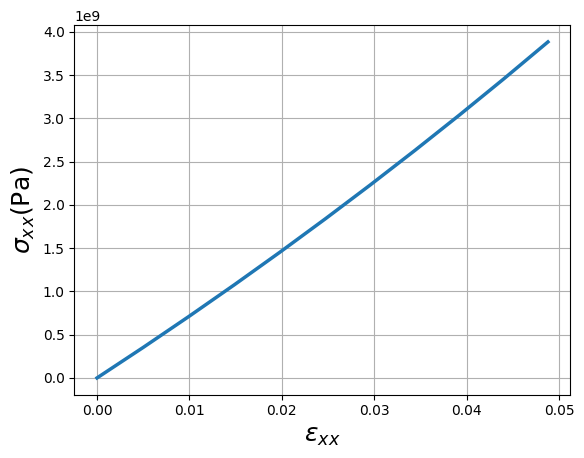

In [10]:
# plot the strain_xx vs stress_xx profile
job.plot_stress_strain(component='xx')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varepsilon_{vM}$', ylabel='$\\sigma_{vM}$ (Pa)'>)

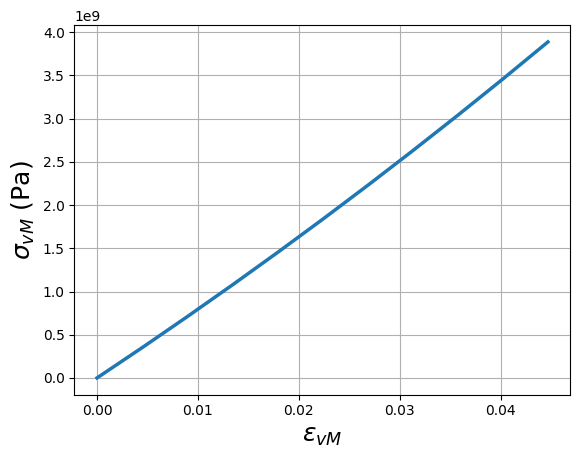

In [11]:
# plot the vonMises-strain vs vonMises-stress profile
job.plot_stress_strain(von_mises=True)

In [12]:
job.writeresults2vtk() # you can also save all the field quantities to vtk files

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
